In [2]:
import os
from collections import OrderedDict
import logging

import numpy as np
from astropy.table import Table

import proxmin
import deblender

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

logger = logging.getLogger("deblender")
logger.setLevel(logging.INFO)
logger2 = logging.getLogger("proxmin")
logger2.setLevel(logging.INFO)

# 1D Translation

Not necessary anymore but it is saved to record the work done that lead to the 2D solution

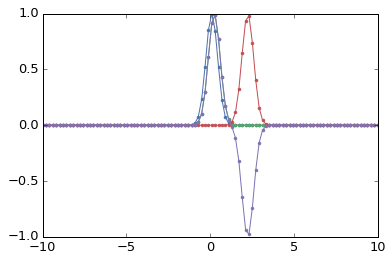

Solutions:


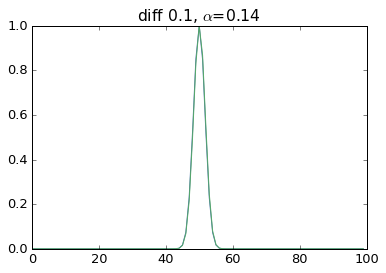

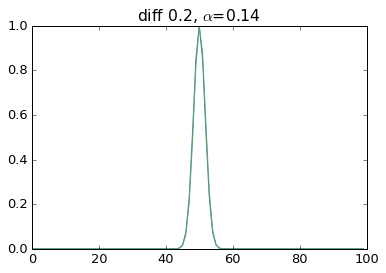

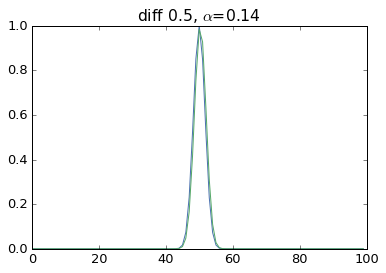

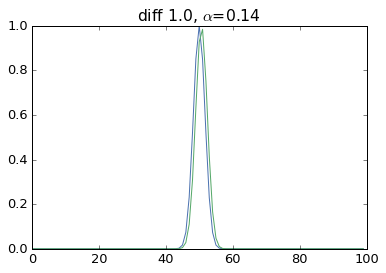

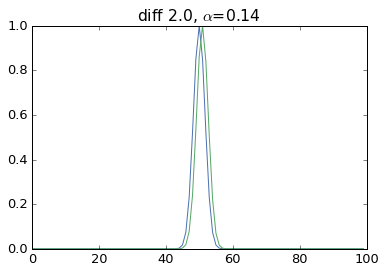

In [195]:
def gaussian(x, x0, A=1, sigma=.25):
    return A*np.exp(-(x-x0)**2/sigma)

x = np.linspace(-10,10,100)
px = .1
dx = .25

data = gaussian(x, px)
model = gaussian(x, dx)
diff = gaussian(x, dx+ddx)
dipole = model-diff

plt.plot(x,data, '.-')
plt.plot(x,model, '.-')
plt.plot(x,diff, '.-')
plt.plot(x,dipole, '.-')
plt.show()

print("Solutions:")

differential = [.1,.2,.5,1.,2.]
for ddx in differential:
    diff = gaussian(x, dx+ddx)
    dipole = (model-diff)/ddx
    A = -dipole.reshape(len(dipole),1)
    y = data-model
    alpha, = np.linalg.lstsq(A, y)[0]
    plt.plot(data)
    #plt.plot(model-alpha*dipole)
    mx = gaussian(x, dx+alpha)
    plt.plot(mx)
    plt.title("diff {0}, $\\alpha$={1:.2f}".format(ddx, m))
    plt.show()

# 2D Translation Test

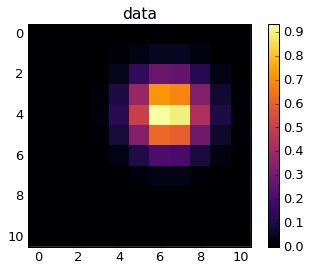

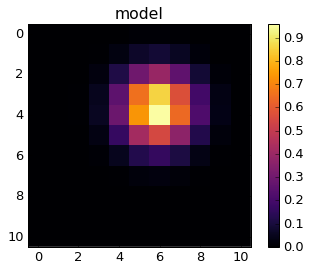

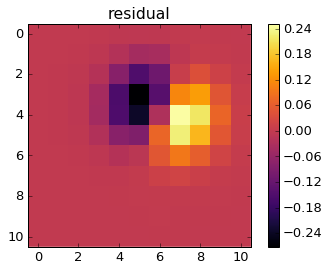

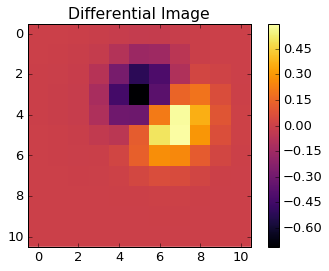

0.512454684494 0.215639964779


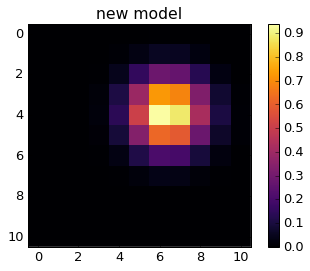

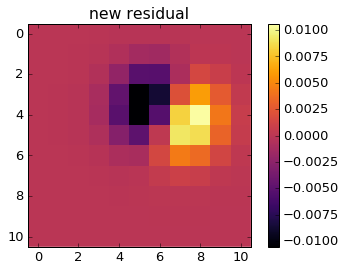

In [196]:
def gaussian2D(x, y, x0=0, y0=0, A=1, sigma=1.5):
    return A*np.exp(-0.5*((x-x0)**2+(y-y0)**2)/sigma)

width = 11
height = 11
px = 1.435
py = -1.108
dx = .9
dy = -1.333

x = np.linspace(-5,5,width)
y = np.linspace(-5,5,height)
X,Y = np.meshgrid(x,y)
data = gaussian2D(X, Y, px, py)
model = gaussian2D(X, Y, dx, dy)
plt.imshow(data)
plt.colorbar()
plt.title("data")
plt.show()
plt.imshow(model)
plt.colorbar()
plt.title("model")
plt.show()

plt.imshow(data-model)
plt.colorbar()
plt.title("residual")
plt.show()

dxy = .1
diffX = gaussian2D(X, Y, dx+dxy, dy)
dipoleX = (model-diffX)/dxy
diffY = gaussian2D(X, Y, dx, dy+dxy)
dipoleY = (model-diffY)/dxy
plt.imshow(-dipoleY-dipoleX)
plt.title("Differential Image")
plt.colorbar()
plt.show()

A = np.vstack([-dipoleX.flatten(),-dipoleY.flatten()]).T
y = (data-model).flatten()
ax, ay = np.linalg.lstsq(A, y)[0]
print(ax,ay)
model = gaussian2D(X,Y,dx+ax,dy+ay)
plt.imshow(model)
plt.colorbar()
plt.title("new model")
plt.show()

plt.imshow(data-model)
plt.colorbar()
plt.title("new residual")
plt.show()

# 2D Translation Test with multiple sources

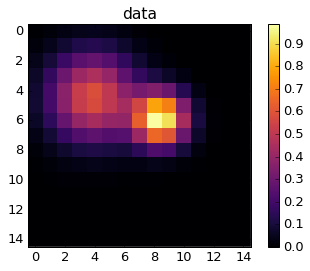

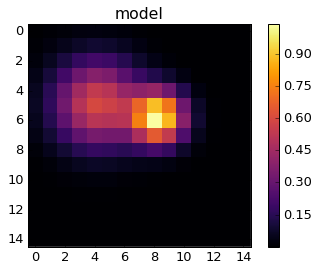

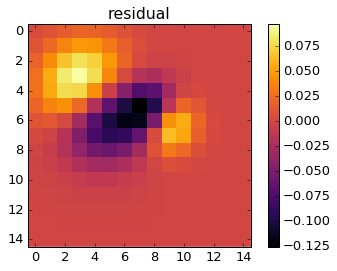

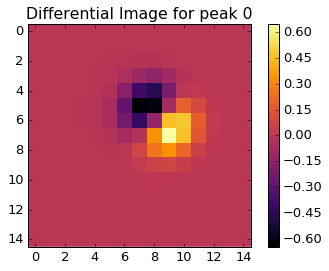

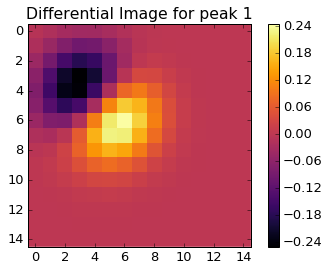

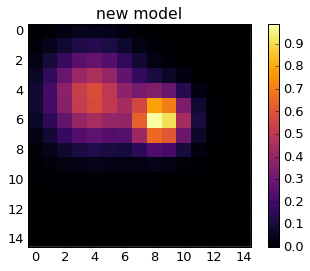

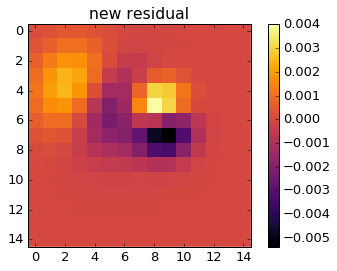

Total initial residual -0.11269639305
Total new residual -0.00409573096764


In [214]:
def gaussian2D(x, y, x0=0, y0=0, A=1, sigma=1.5):
    return A*np.exp(-0.5*((x-x0)**2+(y-y0)**2)/sigma)

width = 15
height = 15

peaks = [
    (1.435, -1.108, 1, 1.5),
    (-3.108, -2.56, .6, 4)
]

deltas = [
    (-.126,-.102),
    (.314,.44)
]
model_peaks = [(px+deltas[n][0], py+deltas[n][1], A, sigma) for n,(px,py,A,sigma) in enumerate(peaks)]

x = np.linspace(-7,7,width)
y = np.linspace(-7,7,height)
X,Y = np.meshgrid(x,y)
data = np.zeros((height,width))
models = []
for n, (px,py,A,sigma) in enumerate(peaks):
    data += gaussian2D(X, Y, px, py, A, sigma)
    dx, dy, A, sigma = model_peaks[n]
    models.append(gaussian2D(X, Y, dx, dy, A, sigma))
models = np.array(models)
model = np.sum(models, axis=0)
plt.imshow(data)
plt.colorbar()
plt.title("data")
plt.show()
plt.imshow(model)
plt.colorbar()
plt.title("model")
plt.show()

plt.imshow(data-model)
plt.colorbar()
plt.title("residual")
plt.show()

dxy = .1
dipoles = []
for n, (dx, dy, A, sigma) in enumerate(model_peaks):
    model = models[n]
    diffX = gaussian2D(X, Y, dx+dxy, dy, A, sigma)
    dipoleX = (model-diffX)/dxy
    diffY = gaussian2D(X, Y, dx, dy+dxy, A, sigma)
    dipoleY = (model-diffY)/dxy
    dipoles.append(dipoleX)
    dipoles.append(dipoleY)

    plt.imshow(-dipoleY-dipoleX)
    plt.title("Differential Image for peak {0}".format(n))
    plt.colorbar()
    plt.show()

model = np.sum(models, axis=0)
A = np.vstack([-dp.flatten() for dp in dipoles]).T
y = (data-model).flatten()
alpha = np.linalg.lstsq(A, y)[0]

new_models = []
for n, (dx, dy, A, sigma) in enumerate(model_peaks):
    new_model = gaussian2D(X, Y, dx+alpha[2*n], dy+alpha[2*n+1], A, sigma)
    new_models.append(new_model)

new_model = np.sum(new_models, axis=0)
plt.imshow(new_model)
plt.colorbar()
plt.title("new model")
plt.show()

plt.imshow(data-new_model)
plt.colorbar()
plt.title("new residual")
plt.show()

model = np.sum(models, axis=0)
print("Total initial residual", np.sum(data-model))
print("Total new residual", np.sum(data-new_model))